In [1]:
import pandas as pd
import os
import shutil
import pickle

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
import numpy as np
import cv2 as cv
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

#from google.colab import drive
#drive.mount('/content/gdrive')

Using TensorFlow backend.


In [2]:
# To get reproducible results 
np.random.seed(1234)
tf.random.set_seed(1234)

Emotion labels in the dataset:
0: -4593 images- Angry
1: -547 images- Disgust
2: -5121 images- Fear
3: -8989 images- Happy
4: -6077 images- Sad
5: -4002 images- Surprise
6: -6198 images- Neutral

In [3]:
if not os.path.exists('fer2013'):
  print("Directory doesn't exist yet. Downloading...")
  !wget -O fer2013.zip "https://cpslo-my.sharepoint.com/:u:/g/personal/lepopal_calpoly_edu/EY30dmi8r1hIi2lkujtWktABxubs0t3Bu2tJuhHKGp7GSA?e=6doqTw&download=1"
  !unzip fer2013*
  print("Done!")
  fer = pd.read_csv('fer2013.csv')
else:
  print("Directory exists. Loading into pandas...")
  fer = pd.read_csv('fer2013.csv')

Directory exists. Loading into pandas...


In [4]:
fer.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
"""
Creates directory structure. 

fer2013
  train
    angry
    disgust
    fear
    happy
    sad
    surprise
    neutral
  validation
    angry
    disgust
    fear
    happy
    sad
    surprise
    neutral
  test
    angry
    disgust
    fear
    happy
    sad
    surprise
    neutral
"""

def save_fer_image(df):
  emotions_exclude = [1] # don't include disgust emotion
  emotions = {0:"angry", 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 
              5:'surprise', 6:'neutral'}
  usages = {'train':'Training', 'validation':'PublicTest', 'test':'PrivateTest'}

  # if folder exists, delete it 
  if os.path.exists('fer2013'):
    shutil.rmtree('fer2013')
    os.mkdir('fer2013')
  else:
    os.mkdir('fer2013')

  for category in ['train', 'validation', 'test']:
    path_name_cat = 'fer2013/' + category
    if not os.path.exists(path_name_cat):
      os.mkdir(path_name_cat)

    emotions_list = list(df['emotion'].unique()) # remove emotions we don't want
    for e in emotions_exclude:
      emotions_list.remove(e)
    
    for emotion in emotions_list:
      emotion_str = emotions[emotion]
      path_name_emotion = os.path.join(path_name_cat, emotion_str)

      if not os.path.exists(path_name_emotion):
        os.mkdir(path_name_emotion)

      for index,row in df[(df['emotion'] == emotion) & (df['Usage'] == usages[category])].iterrows():
        pixels = np.asarray(list(row['pixels'].split(" ")), dtype=np.uint8) # divide by 255 to get floats?
        img = pixels.reshape((48,48))
        file_name = os.path.join(path_name_emotion, str(index) + '.jpg')
        cv.imwrite(file_name, img)

In [6]:
save_fer_image(fer)

Show the first 3 images for each emotion in train folder.

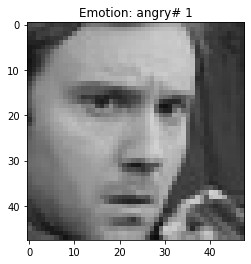

(48, 48, 3)


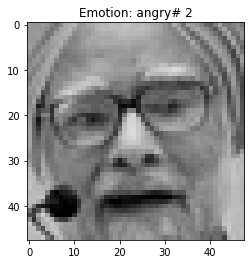

(48, 48, 3)


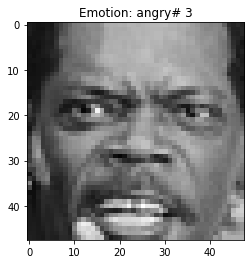

(48, 48, 3)


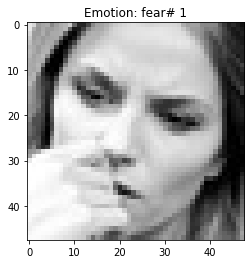

(48, 48, 3)


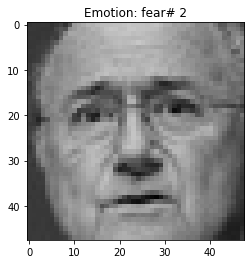

(48, 48, 3)


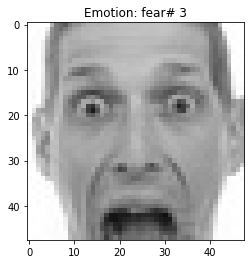

(48, 48, 3)


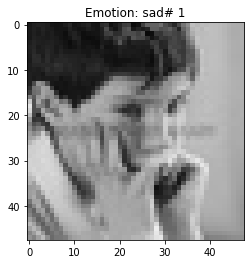

(48, 48, 3)


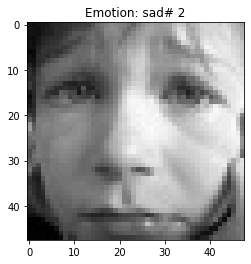

(48, 48, 3)


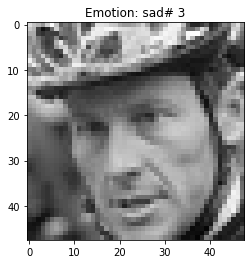

(48, 48, 3)


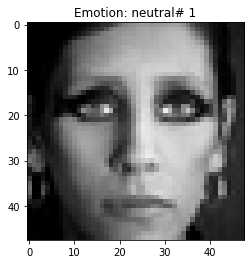

(48, 48, 3)


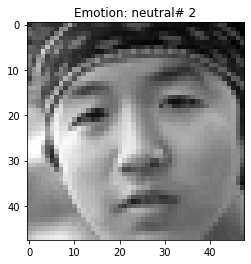

(48, 48, 3)


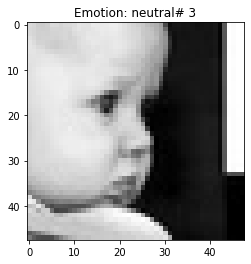

(48, 48, 3)


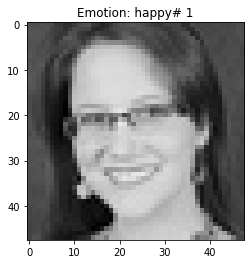

(48, 48, 3)


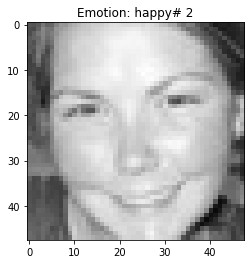

(48, 48, 3)


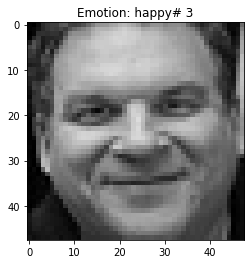

(48, 48, 3)


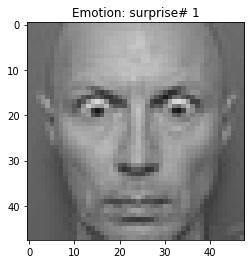

(48, 48, 3)


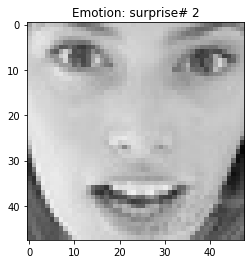

(48, 48, 3)


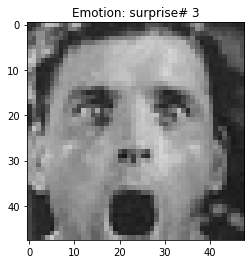

(48, 48, 3)


In [7]:
folder = 'fer2013/train'
for emotion in os.listdir(folder):
  path_name = os.path.join(folder, emotion)
  count = 1
  for img_name in os.listdir(path_name)[:3]:
    file_name = os.path.join(path_name, img_name)
    img = cv.imread(file_name)
    plt.title("Emotion: " + str(emotion) + "# " + str(count))
    plt.imshow(img, cmap='Greys')
    plt.show()
    count += 1
    print(img.shape)


Now that we have the directory structure we can creating the model.

Adapted from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

In [8]:
img_width, img_height = 48, 48

train_data_dir = 'fer2013/train'
validation_data_dir = 'fer2013/validation'

# count the number of training images
nb_train_samples = sum([len(files) for r, d, files in os.walk("fer2013/train")])
# count number of validation images 
nb_validation_samples = sum([len(files) for r, d, files in os.walk("fer2013/validation")])
epochs = 50
batch_size = 128 # change to 32 if too high 

# Consider converting image to grayscale before training?
input_shape = (img_width, img_height, 3)

Create the model.

In [9]:
# Model 4

# model = keras.models.Sequential()
# model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
# model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # size is now 24x24

# model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
# model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
# model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(512, (5, 5),activation='relu',padding='same'))
# model.add(Conv2D(512, (5, 5),activation='relu',padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(128))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

# model.add(Dense(6)) # change to number of emotions to predict
# model.add(Activation('softmax'))

# model.summary()

In [10]:
x_in = Input((48, 48, 3))
# size is 64x64

# First block
x = Conv2D(64,3,padding='same')(x_in)
x = Activation('relu')(x)
x = Conv2D(64,3,padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2,2)(x)
# size is now 32x32

# Second block
x = Conv2D(128,3,padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(128,3,padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2,2)(x)
# size is now 16x16

# Third block
x = Conv2D(256,3,padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(256,3,padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2,2)(x)
# size is now 8x8

# Fourth block
x = Conv2D(512,3,padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(512,3,padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2,2)(x)
# size is now 4x4

# Flatten to a vector
x = Flatten()(x)

# Dense (fully-connected) layer
x = Dense(512)(x) 
x = Activation('relu')(x)

# Output layer
x = Dense(6)(x) # change to number of emotions to predict
x = BatchNormalization()(x)
x = Activation('softmax')(x)

model = Model(inputs=x_in, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7385

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001), # try rmsprop?
              metrics=['accuracy'])

In [12]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')

filepath = "st-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpointer = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

Add image augmentation configuration. Add more augmentations to produce more data. 

In [13]:
from keras.preprocessing.image import ImageDataGenerator
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical') # categorical

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical') # categorical

Found 28273 images belonging to 6 classes.
Found 3533 images belonging to 6 classes.


In [14]:
# Used to resume training of stopped model

# IF there is a model to load then
# model = keras.models.load_model('weights-improvement-13-0.63.hdf5')
# initial_epoch = 13

# ELSE there is no model to load
initial_epoch = 0

In [15]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    shuffle=True,
    callbacks=[lr_reducer, early_stopper, checkpointer],
    initial_epoch=initial_epoch)

Epoch 1/50
220/220 [==============================] - 25s 114ms/step - loss: 1.7506 - accuracy: 0.2403 - val_loss: 3.9271 - val_accuracy: 0.1181

Epoch 00001: val_loss improved from inf to 3.92708, saving model to st-weights-improvement-01-0.12.hdf5
Epoch 2/50
220/220 [==============================] - 23s 105ms/step - loss: 1.6909 - accuracy: 0.2902 - val_loss: 4.4140 - val_accuracy: 0.1169

Epoch 00002: val_loss did not improve from 3.92708
Epoch 3/50
220/220 [==============================] - 23s 106ms/step - loss: 1.6297 - accuracy: 0.3268 - val_loss: 6.0634 - val_accuracy: 0.1486

Epoch 00003: val_loss did not improve from 3.92708
Epoch 4/50
220/220 [==============================] - 24s 108ms/step - loss: 1.5496 - accuracy: 0.3735 - val_loss: 3.9077 - val_accuracy: 0.2399

Epoch 00004: val_loss improved from 3.92708 to 3.90770, saving model to st-weights-improvement-04-0.24.hdf5
Epoch 5/50
220/220 [==============================] - 23s 105ms/step - loss: 1.4742 - accuracy: 0.4097